In [1]:
from dotenv import load_dotenv
load_dotenv()

%load_ext autoreload
%autoreload 2

# Multi-Agent Research System

This notebook combines all the previous components into a single system.

Here is our overall research flow:

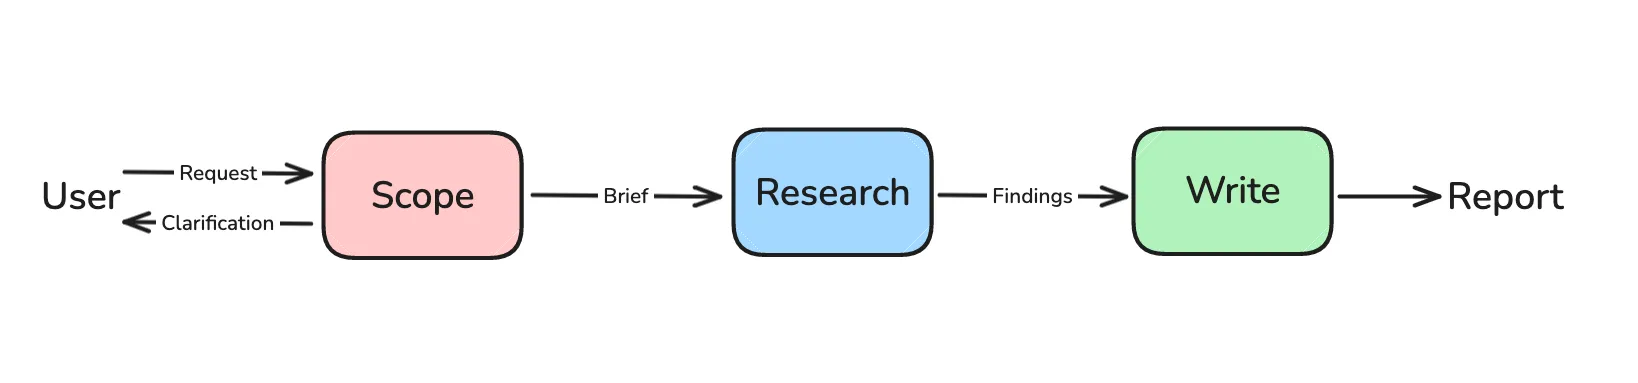

We've built research scoping and multi-agent research in previous notebooks.

Now, we'll add the final report generation step.

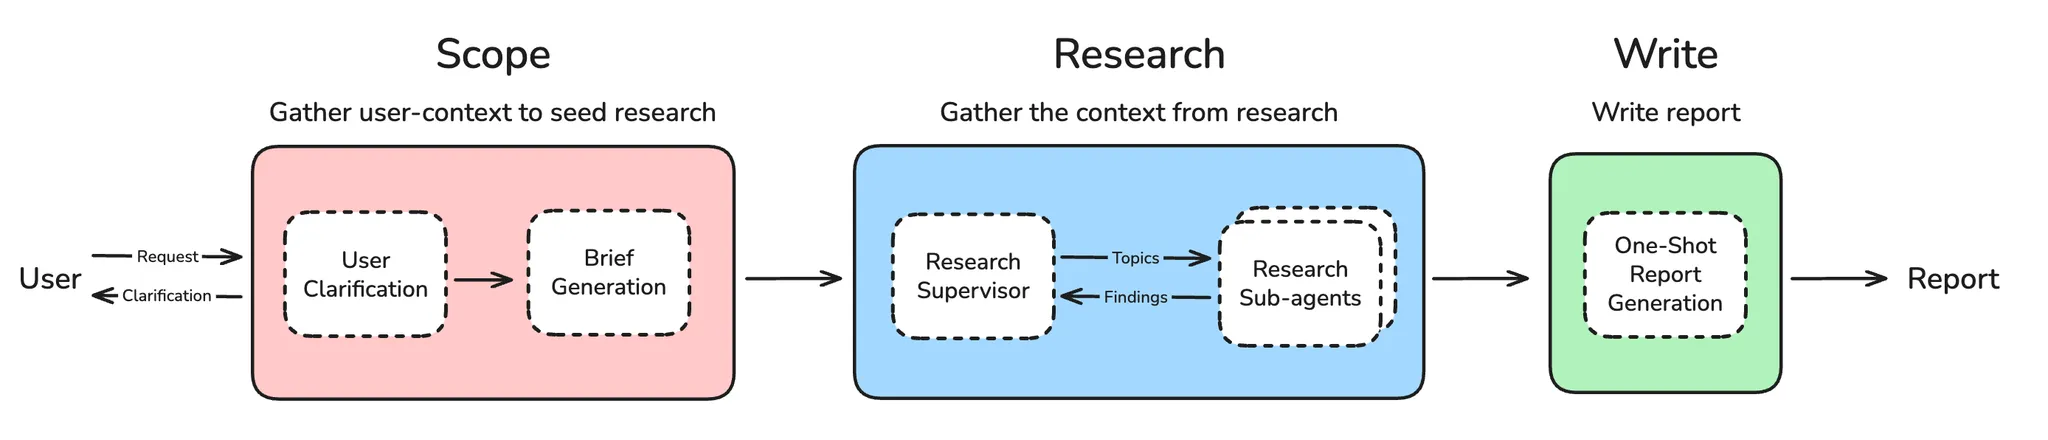

### Agent 

We simply can re-use the components we've already built.

In [2]:
%%writefile ../src/deep_research_from_scratch/research_agent_full.py

"""
Full Multi-Agent Research System

This module integrates all components of the research system:
- User clarification and scoping
- Research brief generation  
- Multi-agent research coordination
- Final report generation

The system orchestrates the complete research workflow from initial user
input through final report delivery.
"""

import os
from langchain_core.messages import HumanMessage
from langgraph.graph import StateGraph, START, END

from deep_research_from_scratch.utils import get_today_str
from deep_research_from_scratch.prompts import final_report_generation_prompt
from deep_research_from_scratch.state_scope import AgentState, AgentInputState
from deep_research_from_scratch.research_agent_scope import clarify_with_user, write_research_brief
from deep_research_from_scratch.multi_agent_supervisor import supervisor_agent

from langchain.chat_models import init_chat_model
writer_model = init_chat_model(
    model="openai:deepseek-v3-1-terminus",
    max_tokens=32000,
    base_url=os.environ.get("OPENAI_BASE_URL"),
    api_key=os.environ.get("OPENAI_API_KEY"),
)

from deep_research_from_scratch.state_scope import AgentState

async def final_report_generation(state: AgentState):
    """
    Final report generation node.
    
    Synthesizes all research findings into a comprehensive final report
    """
    
    notes = state.get("notes", [])
    
    findings = "\n".join(notes)

    final_report_prompt = final_report_generation_prompt.format(
        research_brief=state.get("research_brief", ""),
        findings=findings,
        date=get_today_str()
    )
    
    final_report = await writer_model.ainvoke([HumanMessage(content=final_report_prompt)])
    
    return {
        "final_report": final_report.content, 
        "messages": ["Here is the final report: " + final_report.content],
    }

deep_researcher_builder = StateGraph(AgentState, input_schema=AgentInputState)

deep_researcher_builder.add_node("clarify_with_user", clarify_with_user)
deep_researcher_builder.add_node("write_research_brief", write_research_brief)
deep_researcher_builder.add_node("supervisor_subgraph", supervisor_agent)
deep_researcher_builder.add_node("final_report_generation", final_report_generation)

deep_researcher_builder.add_edge(START, "clarify_with_user")
deep_researcher_builder.add_edge("write_research_brief", "supervisor_subgraph")
deep_researcher_builder.add_edge("supervisor_subgraph", "final_report_generation")
deep_researcher_builder.add_edge("final_report_generation", END)

agent = deep_researcher_builder.compile()

Overwriting ../src/deep_research_from_scratch/research_agent_full.py


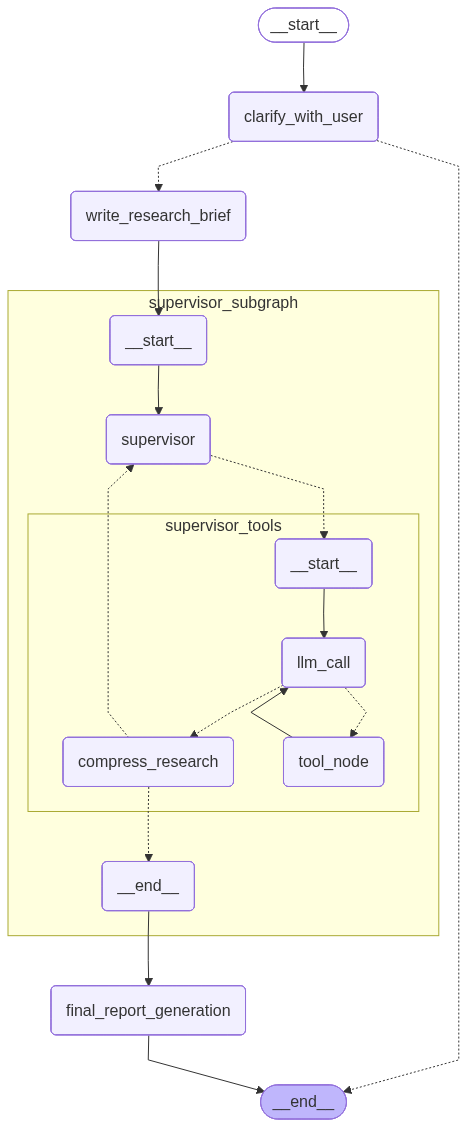

In [3]:
from utils import format_messages
from IPython.display import Image, display
from langgraph.checkpoint.memory import InMemorySaver
from deep_research_from_scratch.research_agent_full import deep_researcher_builder

checkpointer = InMemorySaver()
full_agent = deep_researcher_builder.compile(checkpointer=checkpointer)
display(Image(full_agent.get_graph(xray=True).draw_mermaid_png()))

LangGraph has a default recursion limit of 25 steps to prevent infinite loops. For complex research workflows that require iterative rounds of research, this limit needs to be increased. As explained in [LangGraph's troubleshooting guide](https://langchain-ai.github.io/langgraph/troubleshooting/errors/GRAPH_RECURSION_LIMIT/), the recursion limit counts every node execution in the graph. In our multi-agent research system:

- **Single Research Agent**: May take 8-12 steps for tool calls and compression
- **Multi-Agent Supervisor**: Each sub-agent spawned adds additional steps
- **Iterative Research**: Supervisor may conduct multiple rounds of research to fill gaps
- **Full Workflow**: Includes scoping, research brief generation, supervision, and report generation

We set the recursion limit to **50** to accommodate:
- Complex research topics requiring multiple research rounds
- Parallel sub-agent execution
- Deep research with many tool calls
- Complete workflow execution from scoping to final report

This allows the supervisor to conduct iterative rounds of research when initial findings have gaps, ensuring comprehensive coverage of complex research topics.

In [4]:
from langchain_core.messages import HumanMessage
thread = {"configurable": {"thread_id": "1", "recursion_limit": 50}}
result = await full_agent.ainvoke({"messages": [HumanMessage(content="Compare Gemini to OpenAI Deep Research agents.")]}, config=thread)
format_messages(result['messages'])

╭─────────────────────────────────────────────────── 🧑 Human ────────────────────────────────────────────────────╮
│ Compare Gemini to OpenAI Deep Research agents.                                                                  │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭───────────────────────────────────────────────────── 📝 AI ─────────────────────────────────────────────────────╮
│ To ensure I provide the most relevant comparison, could you clarify:                                            │
│                                                                                                                 │
│ 1. **Specific aspects to compare** (e.g., performance, capabilities, architecture, use cases, pricing,          │
│ limitations)                                                                                                    │
│ 2. **Timeframe or version focus** (e.g., current state, specific model versions, historical development)        │
│ 3. **Intended audience or context** (e.g., technical researchers, business decision-makers, general overview)   │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

In [5]:
result = await full_agent.ainvoke({"messages": [HumanMessage(content="Yes the specific Deep Research products.")]}, config=thread)

In [6]:
format_messages(result['messages'])

╭─────────────────────────────────────────────────── 🧑 Human ────────────────────────────────────────────────────╮
│ Compare Gemini to OpenAI Deep Research agents.                                                                  │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭───────────────────────────────────────────────────── 📝 AI ─────────────────────────────────────────────────────╮
│ To ensure I provide the most relevant comparison, could you clarify:                                            │
│                                                                                                                 │
│ 1. **Specific aspects to compare** (e.g., performance, capabilities, architecture, use cases, pricing,          │
│ limitations)                                                                                                    │
│ 2. **Timeframe or version focus** (e.g., current state, specific model versions, historical development)        │
│ 3. **Intended audience or context** (e.g., technical researchers, business decision-makers, general overview)   │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭─────────────────────────────────────────────────── 🧑 Human ────────────────────────────────────────────────────╮
│ Yes the specific Deep Research products.                                                                        │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭───────────────────────────────────────────────────── 📝 AI ─────────────────────────────────────────────────────╮
│ I understand you want a comparison of the specific Deep Research products from Gemini and OpenAI. I will now    │
│ begin researching these products to provide you with a comprehensive comparison.                                │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭─────────────────────────────────────────────────── 🧑 Human ────────────────────────────────────────────────────╮
│ Here is the final report: # 深度研究产品对比：Google Gemini 与 OpenAI（截至2025年12月）                         │
│                                                                                                                 │
│ ## 执行摘要                                                                                                     │
│                                                                                                                 │
│ 截至2025年12月，生成式AI领域的竞争已进入白热化阶段。Google于2025年11月发布了Gemini                              │
│ 3，而OpenAI则于2025年12月推出了GPT-5.2作为回应。这两家公司的"深度研究"产品代表了当前AI能力的最高水平，旨在处理  │
│ 复杂的多步骤研究任务。本报告将从性能、架构、用例、定价和局限性等方面，对这两大平台进行全面的技术比较。          │
│                                                                                                                 │
│ ## Google Gemini 深度研究能力                                                                                   │
│                                                                                                                 │
│ ### 产品概述与发布状态                                                                                          │
│                                                                                                                 │
│ Google Gemini                                                                                                   │
│ 3于2025年11月正式发布，被描述为"我们最智能的模型，结合了Gemini的所有能力"[2]。该模型自2025年11月18日起在Google  │
│ 产品生态中全面可用，包括Gemini应用、搜索中的AI模式、AI Studio、Vertex AI以及新的代理开发平台Google              │
│ Antigravity[2]。                                                                                                │
│                                                                                                                 │
│ ### 性能与基准测试                                                                                              │
│                                                                                                                 │
│ Gemini 3在多项基准测试中表现出色：                                                                              │
│ - 在LMArena上获得突破性的1501 Elo分数[2]                                                                        │
│ - 在"人类最后考试"测试中达到博士级推理水平（37.5%），在GPQA Diamond测试中达到91.9%[2]                           │
│ - 在WebDev Arena排行榜上以1420 Elo分数领先[1]                                                                   │
│ - 在学术推理、数学和编码等领域优于Claude Sonnet 4.5和GPT-5.1等竞争对手[3]                                       │
│                                                                                                                 │
│ ### 架构与技术特点                                                                                              │
│                                                                                                                 │
│ Gemini 3采用了先进的架构设计：                                                                                  │
│ - 具备"最先进的推理能力，能够理解深度和细微差别"[2]                                                             │
│ - 包含"强大的世界模型，具有高级视觉推理、强大的函数调用和精确的指令遵循能力"[1]                                 │
│ - 设计用于直观开发，允许用户"从概念到工作应用程序"的直接转换[1]                                                 │
│ - 具有"先进的多模态理解、高级推理和改进的代理编码能力"[3]                                                       │
│                                                                                                                 │
│ ### 深度研究功能与用例                                                                                          │
│                                                                                                                 │
│ Gemini的深度研究能力通过不同的订阅层级提供：                                                                    │
│ - **Deep Think模式**：进一步推动推理能力，在Gemini 3的推理和多模态理解能力上实现阶跃式提升[2]                   │
│ - **多模态信息合成**：帮助用户通过学习多模态信息合成来学习[2]                                                   │
│ - **高级代理能力*

In [7]:
from rich.markdown import Markdown
Markdown(result["final_report"])

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃                           深度研究产品对比：Google Gemini 与 OpenAI（截至2025年12月）                           ┃
┗━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┛


                                                     执行摘要                                                      

截至2025年12月，生成式AI领域的竞争已进入白热化阶段。Google于2025年11月发布了Gemini                                 
3，而OpenAI则于2025年12月推出了GPT-5.2作为回应。这两家公司的"深度研究"产品代表了当前AI能力的最高水平，旨在处理复杂 
的多步骤研究任务。本报告将从性能、架构、用例、定价和局限性等方面，对这两大平台进行全面的技术比较。                 


                                            Google Gemini 深度研究能力                                             

                                                产品概述与发布状态                                                 

Google Gemini                                                                                                      
3于2025年11月正式发布，被描述为"我们最智能的模型，结合了Gemini的所有能力"[2]。该模型自2025年11月18日起在Google产品 
生态中全面可用，包括Gemini应用、搜索中的AI模式、AI Studio、Vertex AI以及新的代理开发平台Google Antigravity[2]。    

                                                  性能与基准测试                                                   

Gemini 3在多项基准测试中表现出色：                                                                                 

 • 在LMArena上获得突破性的1501 Elo分数[2]                                                                          
 • 在"人类最后考试"测试中达到博士级推理水平（37.5%），在GPQA Diamond测试中达到91.9%[2]                             
 • 在WebDev Arena排行榜上以1420 Elo分数领先[1]                                                                     
 • 在学术推理、数学和编码等领域优于Claude Sonnet 4.5和GPT-5.1等竞争对手[3]                                         

                                                  架构与技术特点                                                   

Gemini 3采用了先进的架构设计：                                                                                     

 • 具备"最先进的推理能力，能够理解深度和细微差别"[2]                                                               
 • 包含"强大的世界模型，具有高级视觉推理、强大的函数调用和精确的指令遵循能力"[1]                                   
 • 设计用于直观开发，允许用户"从概念到工作应用程序"的直接转换[1]                                                   
 • 具有"先进的多模态理解、高级推理和改进的代理编码能力"[3]                                                         

                                                深度研究功能与用例                                                 

Gemini的深度研究能力通过不同的订阅层级提供：                                                                       

 • Deep Think模式：进一步推动推理能力，在Gemini 3的推理和多模态理解能力上实现阶跃式提升[2]                         
 • 多模态信息合成：帮助用户通过学习多模态信息合成来学习[2]                                                         
 • 高级代理能力：处理多步骤任务，具备增强的长视野代理能力[2]                                                       

主要应用场景包括帮助用户学习、通过改进的编码和Web开发功能进行构建，以及通过增强的长视野代理能力进行规划[2]。       

                                                定价模型与订阅层级                                                 

Google提供了分层定价结构：                                                                                         

 • 免费层：带有使用上限，禁用深度研究、NotebookLM集成和Google Drive基础等特定功能[4]                               
 • AI Plus：5美元/月，在40多个国家提供扩展的使用限制[4]                                                            
 • AI Pro：19.99美元/月，包含Gemini 2.5 Pro、深度研究、NotebookLM集成和2TB存储[4]                                  
 • AI Ultra：249.99美元/月，针对重度用户和组织，包含30TB存储、早期访问Veo 3视频生成模型和Project Mariner[5]        
 • 企业解决方案：Workspace集成和独立的Gemini Enterprise计划（30美元/用户/月）[4]                                   

                                                 局限性与注意事项                                                  

 • Deep Think模式在完成额外安全评估后仅对Google AI Ultra订阅者可用[2]                                              
 • 免费层用户无法访问完整的深度研究功能[4]                                                                         
 • 某些高级功能可能需要特定的硬件或基础设施支持                                                                    


                                      

### LangGraph Studio

Just as we did before, we can also use LangGraph Studio to visualize the agent. 

The files we wrote with `%%writefile` to `src/deep_research_from_scratch/` during the all the notebooks create the files for our application:

```
deep_research_from_scratch/
├── src/deep_research_from_scratch/
│   ├── state.py          # State definitions
│   ├── scope_research.py # Scoping workflow
│   ├── prompts.py        # Prompt templates
│   └── ...
├── notebooks/            # Development notebooks
├── pyproject.toml        # Dependencies
└── langgraph.json        # LangGraph configuration
```

This agent has been added to the `langgraph.json` file, so you can select `research_agent_full` in the dropdown menu:

```
"research_agent_full": "./src/deep_research_from_scratch/research_agent_full.py:agent"
```

Run the following command to start the studio

```bash
uvx --refresh --from "langgraph-cli[inmem]" --with-editable . --python 3.11 langgraph dev --allow-blocking
```